In [ ]:
!pip3 install torch torchvision
!pip3 install ipympl ipywidgets

In [13]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as functional
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import IPython

from torch.utils.data import TensorDataset, DataLoader
from IPython.display import Image, display

Experiment configuration.

In [62]:
# Mathematical function to approximate.
def f(x):
    return torch.sin(x)

# Training data parameters.
x_min = -20
x_max = 20
x_increment = 0.1 # For visualization
train_count = 1024
seed = torch.Generator().manual_seed(10)
learning_rate = 1e-3
epochs= 100
batch_size = 10
optimizer_f = torch.optim.Adam

# The dimensions of each layer
layer_dimensions = [(1, 10),(10, 10),(10, 10),(10, 1)]

# Loss function
loss_f = nn.MSELoss()

# Device (cpu or gpu)
device = "cpu"

A fully connected neural network (FNN) that approximates the given mathematical function for the given input range.

In [47]:
class FNN(nn.Module):
    def __init__(self):
        super(FNN, self).__init__()

        self.layers = nn.ModuleList()

        for i in range(0, len(layer_dimensions)):
            in_dim = layer_dimensions[i][0]
            out_dim = layer_dimensions[i][1]
            self.layers.append(nn.Linear(in_dim, out_dim))

    def forward(self, x):
        for i in range(0, len(self.layers)):
            layer = self.layers[i]

            if i == len(self.layers) - 1:
                # Last layer does not use an activation function
                x = layer(x)
            else:
                x = functional.relu(layer(x))

        return x

The training procedure.

Epoch   100 | loss_train=0.00029 | loss_validation=0.00029
epoch_list length 100
training_losses length 100


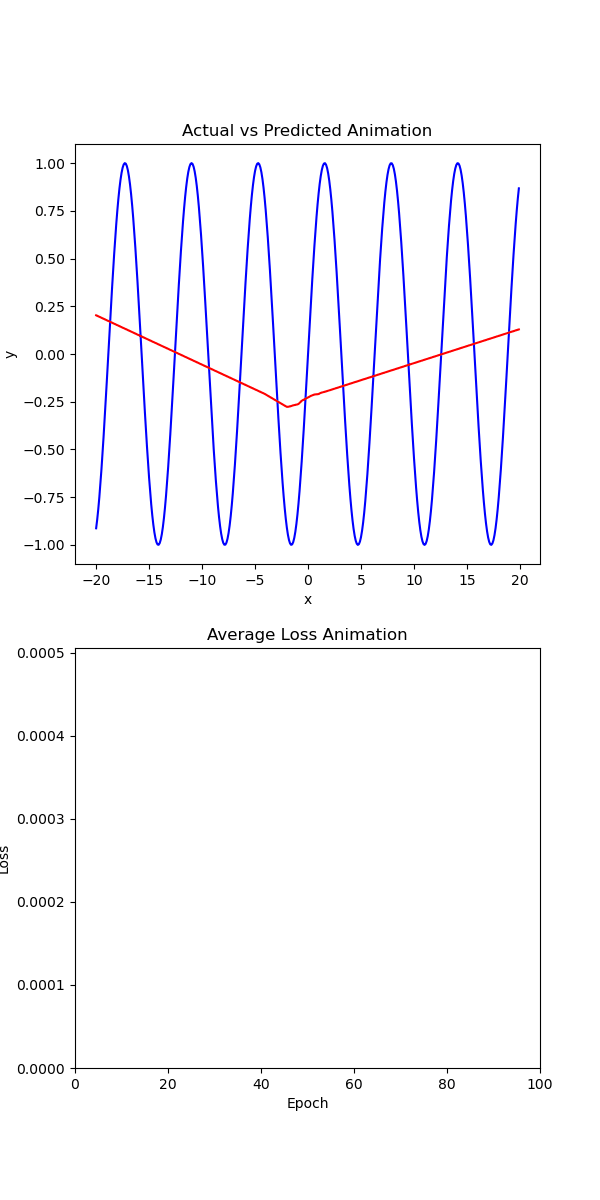

In [64]:
model = FNN()
model.to(device)

x_train = (x_max - x_min) * torch.rand(train_count, 1, generator=seed) + x_min
x_validation = (x_max - x_min) * torch.rand(train_count, 1, generator=seed) + x_min
x_test = torch.arange(x_min, x_max, x_increment).unsqueeze(1)

y_train = f(x_train)
y_validation = f(x_validation)

x_train = x_train.to(device)
y_train = y_train.to(device)

dataset_train = TensorDataset(x_train, y_train)
train_loader = DataLoader(dataset_train, batch_size=batch_size)

optimizer = optimizer_f(model.parameters(), lr=learning_rate)

training_losses = []
validation_losses = []
y_predicted_test = []

for epoch in range(1, epochs + 1):
    model.train()

    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        loss_train = loss_f(model(x_batch), y_batch)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

    model.eval()

    with torch.no_grad():
        loss_train = loss_f(model(x_train), y_train).detach().cpu().item() / x_train.shape[0];
        training_losses.append(loss_train)

        loss_validation = loss_f(model(x_validation), y_validation).detach().cpu().item() / x_validation.shape[0];
        validation_losses.append(loss_validation)

        y_epoch_predicted_test = model(x_test)
        y_predicted_test.append(y_epoch_predicted_test)

    if epoch != 0:
        print("\r", end="")

    print(f"Epoch {epoch:5d} | loss_train={loss_train:.5f} | loss_validation={loss_validation:.5f}", end="")

print("")

y_actual_test = f(x_test).tolist()
x_test = x_test.tolist()
epoch_list = list(range(0, epochs))

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 12))

axs[0].set_title("Actual vs Predicted Animation")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

actual_plot, = axs[0].plot(x_test, y_actual_test, 'b-', label="Actual")
predicted_plot, = axs[0].plot([], [], 'r-', label="Predicition")

axs[1].set_title("Learning Curve Animation")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].set_xlim([0, epochs])
axs[1].set_ylim([0, max([max(training_losses), max(validation_losses)])])

training_loss_plot, = axs[1].plot([], [], 'b-', label="Training")
validation_loss_plot, = axs[1].plot([], [], 'r-', label="Validation")

def update_actual_predicted(index):
    predicted_plot.set_data(x_test, y_predicted_test[index].tolist())
    training_loss_plot.set_data(epoch_list[0:index], training_losses[0:index])
    validation_loss_plot.set_data(epoch_list[0:index], validation_losses[0:index])

    return (actual_plot, predicted_plot, training_loss_plot, validation_loss_plot)

anim = animation.FuncAnimation(fig=fig, func=update_actual_predicted, frames=epochs, interval=100)
anim.save('animation.gif', writer='pillow', fps=1.5)
image = Image('animation.gif')
display(image)

plt.close(fig)